# Лабораторная работа №3
## Выполнил: Концебалов О.С.
## Группа: М8О-409Б-22

## РЕШАЮЩИЕ ДЕРЕВЬЯ
### Для задачи классификации

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv('heart.csv')
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


baseline_tree = DecisionTreeClassifier(random_state=42)
baseline_tree.fit(X_train, y_train)
train_pred_baseline = baseline_tree.predict(X_train)
test_pred_baseline = baseline_tree.predict(X_test)
print("base")
print("depth", baseline_tree.get_depth())
print("\ntrain")
print("accuracy:", accuracy_score(y_train, train_pred_baseline))
print("F1-score:", f1_score(y_train, train_pred_baseline))
print("\ntest:")
print("accuracy:", accuracy_score(y_test, test_pred_baseline))
print("F1-score:", f1_score(y_test, test_pred_baseline))
print("\ndelta (Train-Test):", accuracy_score(y_train, train_pred_baseline) - accuracy_score(y_test, test_pred_baseline))

base
depth 9

train
accuracy: 1.0
F1-score: 1.0

test:
accuracy: 0.9853658536585366
F1-score: 0.9855072463768115

delta (Train-Test): 0.014634146341463428


Переобучения нет, визуализируем. Метрики хорошие

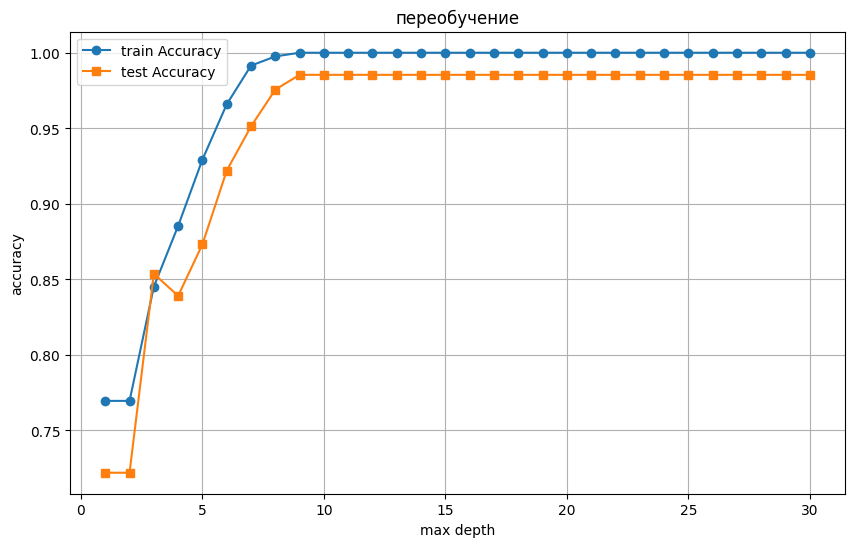

In [6]:
depths = range(1, 31)
train_scores = []
test_scores = []
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, tree.predict(X_train)))
    test_scores.append(accuracy_score(y_test, tree.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='train Accuracy', marker='o')
plt.plot(depths, test_scores, label='test Accuracy', marker='s')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('переобучение')
plt.legend()
plt.grid(True)
plt.show()

Ограничим глубину до 5. Должны увидеть точность около 0.85

In [8]:
tree_depth_limited = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_depth_limited.fit(X_train, y_train)

print("max_depth=5")
print("accuracy", accuracy_score(y_test, tree_depth_limited.predict(X_test)))
print("F1-score ", f1_score(y_test, tree_depth_limited.predict(X_test)))

max_depth=5
accuracy 0.8731707317073171
F1-score  0.8785046728971964


Теперь поработаем с сэмплами

In [11]:
tree_min_samples = DecisionTreeClassifier(
    min_samples_leaf=10,
    min_samples_split=20,
    random_state=42
)
tree_min_samples.fit(X_train, y_train)
print("min_samples_leaf=10, min_samples_split=20")
print("accuracy", accuracy_score(y_test, tree_min_samples.predict(X_test)))
print("F1-score", f1_score(y_test, tree_min_samples.predict(X_test)))

min_samples_leaf=10, min_samples_split=20
accuracy 0.8780487804878049
F1-score 0.8792270531400966


Сделаем подбор параметров 

In [14]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

tree_gs = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    tree_gs,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)
y_pred_best_tree = best_tree.predict(X_test)
y_pred_proba_best_tree = best_tree.predict_proba(X_test)[:, 1]

print("grid")
print("depth", best_tree.get_depth())
print("листья", best_tree.get_n_leaves())
print("Accuracy", accuracy_score(y_test, y_pred_best_tree))
print("F1-score", f1_score(y_test, y_pred_best_tree))
print("ROC-AUC", roc_auc_score(y_test, y_pred_proba_best_tree))


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
grid
depth 9
листья 49
Accuracy 1.0
F1-score 1.0
ROC-AUC 1.0


Подтюним балансировку

In [16]:
tree_balanced = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42,
    max_depth=5
)
tree_balanced.fit(X_train, y_train)
y_pred_balanced = tree_balanced.predict(X_test)
print("balanced")
print("accuracy:", accuracy_score(y_test, y_pred_balanced))

balanced
accuracy: 0.8731707317073171


Сделаем свою реализацию

In [17]:
class CustomDecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = value is not None

class CustomDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        
    def _gini(self, y):
        if len(y) == 0:
            return 0
        p1 = np.sum(y == 1) / len(y)
        return 1 - p1**2 - (1-p1)**2
    
    def _best_split(self, X, y):
        m, n = X.shape
        if m <= self.min_samples_split:
            return None, None            
        best_gini = float('inf')
        best_feature, best_threshold = None, None        
        for feature_idx in range(n):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold               
                if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
                    continue              
                gini_left = self._gini(y[left_indices])
                gini_right = self._gini(y[right_indices])
                weighted_gini = (np.sum(left_indices) * gini_left + np.sum(right_indices) * gini_right) / m
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_idx
                    best_threshold = threshold
        return best_feature, best_threshold
    def _build_tree(self, X, y, depth=0):
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or 
            len(np.unique(y)) == 1):
            return CustomDecisionTreeNode(value=np.round(np.mean(y)))
        feature_idx, threshold = self._best_split(X, y)
        if feature_idx is None:
            return CustomDecisionTreeNode(value=np.round(np.mean(y)))
        left_indices = X[:, feature_idx] <= threshold
        right_indices = X[:, feature_idx] > threshold
        if (np.sum(left_indices) < self.min_samples_leaf or 
            np.sum(right_indices) < self.min_samples_leaf):
            return CustomDecisionTreeNode(value=np.round(np.mean(y)))
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return CustomDecisionTreeNode(
            feature_index=feature_idx,
            threshold=threshold,
            left=left_subtree,
            right=right_subtree)
    
    def fit(self, X, y):
        self.root = self._build_tree(np.array(X), np.array(y))
    
    def _predict_single(self, x, node):
        if node.is_leaf:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)
    
    def predict(self, X):
        return np.array([self._predict_single(x, self.root) for x in np.array(X)])

    
custom_tree = CustomDecisionTree(max_depth=5, min_samples_split=10, min_samples_leaf=5)
custom_tree.fit(X_train, y_train)
y_pred_custom = custom_tree.predict(X_test)

print("my")
print("accuracy", accuracy_score(y_test, y_pred_custom))
print("F1-score", f1_score(y_test, y_pred_custom))

my
accuracy 0.8829268292682927
F1-score 0.8834951456310681


Метрики хорошие, подберем глубину для разнообразия по F1

In [18]:
custom_tree_depths = [3, 5, 7, 10]
best_custom_f1 = 0
best_custom_depth = 5
for depth in custom_tree_depths:
    tree = CustomDecisionTree(
        max_depth=depth,
        min_samples_split=10,
        min_samples_leaf=5)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"Depth={depth}: F1-score={f1:.4f}")
    if f1 > best_custom_f1:
        best_custom_f1 = f1
        best_custom_depth = depth

print(f"\depth {best_custom_depth}")
print(f"F1-score {best_custom_f1:.4f}")

final_custom_tree = CustomDecisionTree(
    max_depth=best_custom_depth,
    min_samples_split=10,
    min_samples_leaf=5
)
final_custom_tree.fit(X_train, y_train)
y_pred_final_custom = final_custom_tree.predict(X_test)

Depth=3: F1-score=0.8611
Depth=5: F1-score=0.8835
Depth=7: F1-score=0.9135
Depth=10: F1-score=0.9135
\depth 7
F1-score 0.9135


### Для задачи регрессии

Обучим базовую модель

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X = train.drop(['Id', 'SalePrice'], axis=1)
y = train['SalePrice']
def basic_rf_preprocessing(df, label_encoders=None):
    df = df.copy()
    if label_encoders is None:
        label_encoders = {}
        is_train = True
    else:
        is_train = False    
    for col in df.columns:
        if df[col].dtype == 'object':
            if is_train:
                le = LabelEncoder()
                df[col] = df[col].fillna('missing')
                df[col] = le.fit_transform(df[col])
                label_encoders[col] = le
            else:
                le = label_encoders.get(col)
                if le:
                    df[col] = df[col].fillna('missing')
                    df[col] = df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        else:
            df[col] = df[col].fillna(df[col].median())
    return df, label_encoders

X_processed, label_encoders = basic_rf_preprocessing(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
base_rf = RandomForestRegressor(n_estimators=100, random_state=42)
base_rf.fit(X_train, y_train)
y_pred_base = base_rf.predict(X_test)
base_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_base)),
    'MAE': mean_absolute_error(y_test, y_pred_base),
    'test R2': r2_score(y_test, y_pred_base),
    'train R2': base_rf.score(X_train, y_train)
}

print("base")
for metric, value in base_metrics.items():
    print(f"{metric}: {value:.2f}")

base
RMSE: 28409.03
MAE: 17561.65
test R2: 0.89
train R2: 0.98


Разница между R2 близка к 0.1 - возможно незначительное, но приемлемое переобучение. Взглянем на признаки

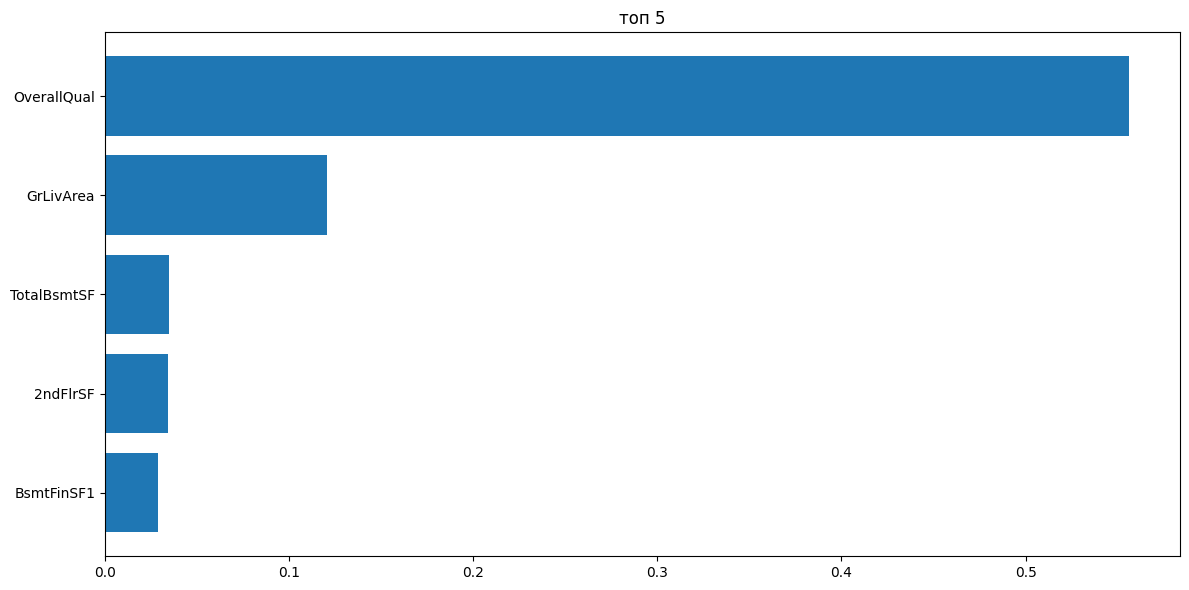

In [11]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': base_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance.head(5)['feature'][::-1], 
         feature_importance.head(5)['importance'][::-1])
plt.title('топ 5')
plt.tight_layout()
plt.show()

Попробуем провести препроцессинг похожий на предыдущий, но скорее всего для деревьев он не должен показать вау результата. Также посмотрим гиперпараметры 

In [18]:
def enhanced_rf_preprocessing(df, is_train=True, stats_dict=None):
    df = df.copy()
    if stats_dict is None:
        stats_dict = {}
        is_train = True
    df['TotalSF'] = df.get('TotalBsmtSF', 0) + df.get('1stFlrSF', 0) + df.get('2ndFlrSF', 0)
    df['TotalBath'] = df.get('FullBath', 0) + 0.5 * df.get('HalfBath', 0)
    df['HouseAge'] = df.get('YrSold', 0) - df.get('YearBuilt', 0)
    df['Qual_Area'] = df.get('OverallQual', 0) * df.get('GrLivArea', 0)
    for col in df.columns:
        if col not in stats_dict and is_train:
            if df[col].dtype == 'object':
                stats_dict[col] = ('mode', df[col].mode()[0] if not df[col].mode().empty else 'missing')
            else:
                stats_dict[col] = ('median', df[col].median()) 
        if col in stats_dict:
            stat_type, stat_value = stats_dict[col]
            if stat_type == 'mode':
                df[col] = df[col].fillna(stat_value)
            else:
                df[col] = df[col].fillna(stat_value)
    cat_cols = df.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        if is_train:
            for col in cat_cols:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                stats_dict[f'encoder_{col}'] = le
        else:
            for col in cat_cols:
                le = stats_dict.get(f'encoder_{col}')
                if le:
                    df[col] = df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    return df, stats_dict


X_enh, stats_dict = enhanced_rf_preprocessing(X)
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(X_enh, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [10, 30, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}

rf_for_grid = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_for_grid,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_enh, y_train_enh)

enhanced_rf = grid_search.best_estimator_
enhanced_rf.fit(X_train_enh, y_train_enh)

y_pred_enh = enhanced_rf.predict(X_test_enh)
enhanced_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test_enh, y_pred_enh)),
    'MAE': mean_absolute_error(y_test_enh, y_pred_enh),
    'R2': r2_score(y_test_enh, y_pred_enh),
    'train R2': enhanced_rf.score(X_train_enh, y_train_enh)
}

print("\nenh")
for metric, value in enhanced_metrics.items():
    print(f"{metric}: {value:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits

enh
RMSE: 29250.67
MAE: 17047.44
R2: 0.89
train R2: 0.97


Для удобства визуализируем таблицей

                  RMSE        R2  train R2
base      28409.031554       NaN  0.979864
enhanced  29250.666383  0.888453  0.972190


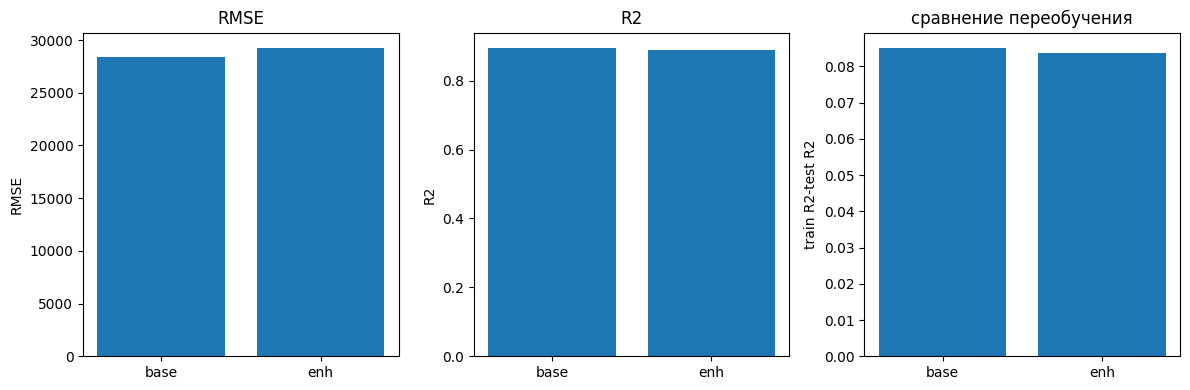

In [22]:
comparison_df = pd.DataFrame({
    'base': base_metrics,
    'enhanced': enhanced_metrics
}).T

print(comparison_df[['RMSE', 'R2', 'train R2']])

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(['base', 'enh'], [base_metrics['RMSE'], enhanced_metrics['RMSE']])
plt.title('RMSE')
plt.ylabel('RMSE')

plt.subplot(1, 3, 2)
plt.bar(['base', 'enh'], [base_metrics['test R2'], enhanced_metrics['R2']])
plt.title('R2')
plt.ylabel('R2')

plt.subplot(1, 3, 3)
base_gap = base_metrics['train R2'] - base_metrics['test R2']
enh_gap = enhanced_metrics['train R2'] - enhanced_metrics['R2']
plt.bar(['base', 'enh'], [base_gap, enh_gap])
plt.title('cравнение переобучения')
plt.ylabel('train R2-test R2')

plt.tight_layout()
plt.show()

Сделаем свою реализацию

In [24]:
class CustomRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None
        if random_state is not None:
            np.random.seed(random_state)
    class DecisionTree:
        def __init__(self, max_depth, min_samples_split, min_samples_leaf, max_features):
            self.max_depth = max_depth
            self.min_samples_split = min_samples_split
            self.min_samples_leaf = min_samples_leaf
            self.max_features = max_features
            self.root = None
        class Node:
            def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
                self.feature_idx = feature_idx
                self.threshold = threshold
                self.left = left
                self.right = right
                self.value = value
        
        def _mse(self, y):
            return np.var(y) if len(y) > 0 else 0
        
        def _get_random_features(self, n_features):
            if self.max_features == 'sqrt':
                n = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                n = int(np.log2(n_features))
            else:
                n = min(self.max_features, n_features)
            return np.random.choice(n_features, n, replace=False)
        
        def _best_split(self, X, y):
            best_mse = float('inf')
            best_split = None
            feature_indices = self._get_random_features(X.shape[1])
            for feature_idx in feature_indices:
                values = X[:, feature_idx]
                thresholds = np.percentile(np.unique(values), [25, 50, 75]) if len(np.unique(values)) > 3 else np.unique(values)
                for threshold in thresholds:
                    left_mask = values <= threshold
                    right_mask = ~left_mask
                    if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                        continue
                    mse_left = self._mse(y[left_mask])
                    mse_right = self._mse(y[right_mask])
                    total_mse = (len(y[left_mask]) * mse_left + len(y[right_mask]) * mse_right) / len(y)
                    
                    if total_mse < best_mse:
                        best_mse = total_mse
                        best_split = (feature_idx, threshold, left_mask, right_mask)
            return best_split
    
        def _build_tree(self, X, y, depth):
            if (len(y) < self.min_samples_split or 
                (self.max_depth is not None and depth >= self.max_depth) or
                len(np.unique(y)) == 1):
                return self.Node(value=np.mean(y))        
            split = self._best_split(X, y)
            if split is None:
                return self.Node(value=np.mean(y))
            feature_idx, threshold, left_mask, right_mask = split
            left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
            right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)
            return self.Node(feature_idx=feature_idx, threshold=threshold, 
                            left=left_child, right=right_child)
        
        def fit(self, X, y):
            self.root = self._build_tree(X, y, 0)
            return self
        
        def _predict_one(self, x, node):
            if node.value is not None:
                return node.value
            if x[node.feature_idx] <= node.threshold:
                return self._predict_one(x, node.left)
            else:
                return self._predict_one(x, node.right)
        
        def predict(self, X):
            return np.array([self._predict_one(x, self.root) for x in X])
    
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def fit(self, X, y):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y
        self.trees = []
        self.feature_importances_ = np.zeros(X.shape[1])
        for i in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            
            tree = self.DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            self._update_feature_importance(tree, X_sample.shape[1])
        
        self.feature_importances_ = self.feature_importances_ / np.sum(self.feature_importances_)
        return self
    
    def _update_feature_importance(self, tree, n_features):
        def count_features(node):
            if node.value is not None:
                return
            if node.feature_idx < n_features:
                self.feature_importances_[node.feature_idx] += 1
            count_features(node.left)
            count_features(node.right)
        count_features(tree.root)
    
    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        return np.mean(predictions, axis=1)
    

    
custom_rf = CustomRandomForest(
    n_estimators=50,  
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

custom_rf.fit(X_train, y_train)

y_pred_custom = custom_rf.predict(X_test)

custom_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_custom)),
    'MAE': mean_absolute_error(y_test, y_pred_custom),
    'R2': r2_score(y_test, y_pred_custom)
}

print("\nmy")
for metric, value in custom_metrics.items():
    print(f"{metric}: {value:.2f}")


my
RMSE: 35232.90
MAE: 18573.72
R2: 0.84


Для ускорения мы ограничим глубину деревьев, изменим класс через oob, но с меньшей глубиной

In [25]:
class EnhancedCustomRandomForest(CustomRandomForest):
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', random_state=None,
                 bootstrap=True, oob_score=False):
        super().__init__(n_estimators, max_depth, min_samples_split, 
                        min_samples_leaf, max_features, random_state)
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.oob_score_ = None
    
    def fit(self, X, y):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y
        self.trees = []
        self.feature_importances_ = np.zeros(X.shape[1])
        n_samples = X.shape[0]
        oob_predictions = np.zeros((n_samples, self.n_estimators))
        oob_counts = np.zeros(n_samples)
        for i in range(self.n_estimators):
            if self.bootstrap:
                indices = np.random.choice(n_samples, n_samples, replace=True)
                oob_indices = np.setdiff1d(np.arange(n_samples), np.unique(indices))
                X_sample, y_sample = X[indices], y[indices]
            else:
                indices = np.arange(n_samples)
                X_sample, y_sample = X, y
                oob_indices = np.array([])   
            tree = self.DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features)
            
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            self._update_feature_importance(tree, X.shape[1])
            if len(oob_indices) > 0 and self.oob_score:
                oob_pred = tree.predict(X[oob_indices])
                oob_predictions[oob_indices, i] = oob_pred
                oob_counts[oob_indices] += 1
        
        self.feature_importances_ = self.feature_importances_ / np.sum(self.feature_importances_)
        if self.oob_score and self.bootstrap:
            mask = oob_counts > 0
            if np.any(mask):
                oob_pred_mean = np.sum(oob_predictions, axis=1)[mask] / oob_counts[mask]
                self.oob_score_ = r2_score(y[mask], oob_pred_mean)
        
        return self

enhanced_custom_rf = EnhancedCustomRandomForest(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    bootstrap=True,
    oob_score=True)
enhanced_custom_rf.fit(X_train_enh, y_train_enh)
y_pred_enh_custom = enhanced_custom_rf.predict(X_test_enh)
enh_custom_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test_enh, y_pred_enh_custom)),
    'MAE': mean_absolute_error(y_test_enh, y_pred_enh_custom),
    'R2': r2_score(y_test_enh, y_pred_enh_custom),
    'OOB Score': enhanced_custom_rf.oob_score_ if enhanced_custom_rf.oob_score_ else 0
}

print("\nmy2")
for metric, value in enh_custom_metrics.items():
    print(f"{metric}: {value:.2f}")


my2
RMSE: 30512.04
MAE: 16913.34
R2: 0.88
OOB Score: 0.85
